In [1]:
from scipy import ndimage
from astropy.io import fits

In [2]:
import scipy.ndimage

In [3]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [4]:
from astropy.io import fits
import reproject
from astropy import convolution
from astropy.convolution import Gaussian2DKernel
from astropy import units as u
from astropy.table import Table
import pyavm

In [5]:
import regions
from astropy import coordinates

In [6]:
import PIL

In [7]:
from spectral_cube import SpectralCube, Projection, Slice

In [8]:
import uvcombine
from astropy import wcs

In [9]:
import matplotlib
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [10]:
import numpy as np

In [11]:
import pylab as pl
from astropy.visualization import simple_norm

In [12]:
basepath = '/orange/adamginsburg/jwst/brick'

In [13]:
img = fits.getdata(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits", ext=1)
header = fits.getheader(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits", ext=1)
ww = wcs.WCS(header)
img.shape

(2329, 5683)

In [14]:
img = fits.getdata(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits", ext=1)
header = fits.getheader(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits", ext=1)
ww = wcs.WCS(header)
img.shape

(4843, 11716)

In [15]:
import intake_astro
import intake_astro.array
import imp
imp.reload(intake_astro)
imp.reload(intake_astro.array)
from intake_astro.array import FITSArraySource

# Initial Experimentation

In [16]:
img.shape

(4843, 11716)

In [17]:
regs = regions.Regions.read(f'{basepath}/regions/bright_stars_short.reg')
if regs is not None:
    for reg in regs:
        preg = reg.to_pixel(ww)
        mask = preg.to_mask()
        slcs,smslcs = mask.get_overlap_slices(img.shape)
        img[slcs][mask.data.astype('bool')[smslcs]] = np.nan
img[img==0] = np.nan

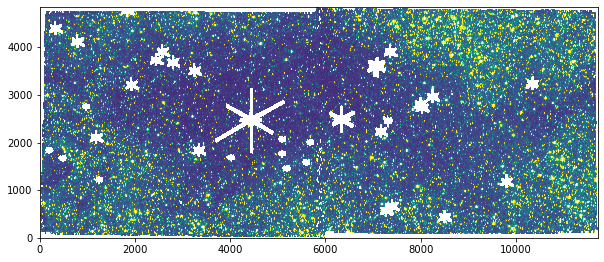

In [18]:
pl.imshow(img, vmin=-1, vmax=25)

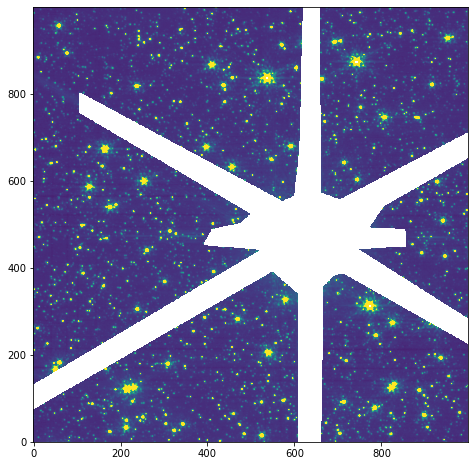

In [19]:
pl.imshow(img[2000:3000, 3800:4800], vmin=-1, vmax=25)

In [20]:
dx = 256
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

38

In [21]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

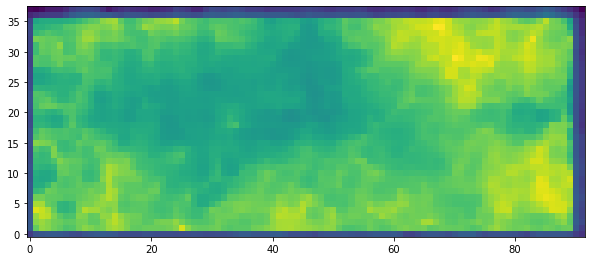

In [22]:
pl.imshow(arr)

In [23]:
dx = 128
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

76

In [24]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

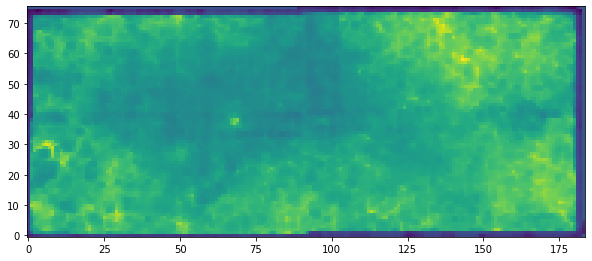

In [25]:
pl.imshow(arr)

In [26]:
dx = 64
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

152

In [27]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

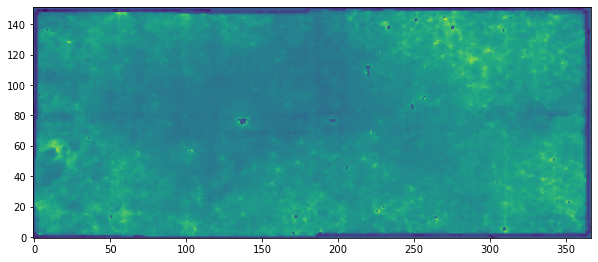

In [28]:
pl.imshow(arr)

In [29]:
dx = 32
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

303

In [30]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

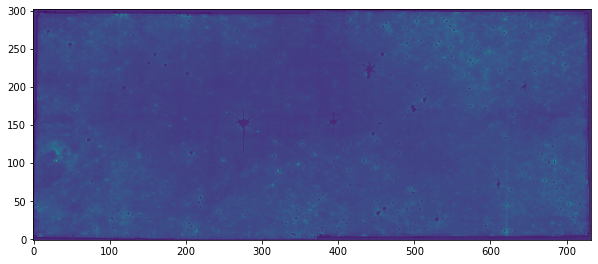

In [31]:
pl.imshow(arr)

# Deployment Version 

In [76]:
import glob
import warnings
import regions
from tqdm.notebook import tqdm

In [77]:
%run $basepath/reduction/destreak.py

old debug cells in the next two; they're covered in the loop below

In [78]:
for fn in glob.glob(f'{basepath}/images/jw02221-o001_t001_nircam_*_i2d.fits'):
    with warnings.catch_warnings():
        # specifically ignoring that we're using non-integer 
        warnings.simplefilter('ignore')
        dx = 128 if 'f4' in fn else 256
        sl = 'long' if 'f4' in fn else 'short'
        regs = regions.Regions.read(f'{basepath}/regions/bright_stars_{sl}.reg')
        tp = compute_zero_spacing_approximation(fn, ext=1, dx=dx, regs=regs, percentile=10, progressbar=tqdm)
        #if np.nanpercentile(tp.data, 10) < 0:
        #    print(np.nanpercentile(tp.data, 10))
        #    tp.data -= np.nanpercentile(tp.data, 10)
        #tp.data[tp.data<0] = 0
        tp.writeto(fn.replace("_i2d.fits", f"_i2d_medfilt{dx}.fits"), overwrite=True)
        print(fn)
        print(fn.replace("_i2d.fits", f"_i2d_medfilt{dx}.fits"))

  0%|          | 0/40 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f212n_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f212n_i2d_medfilt256.fits


  0%|          | 0/40 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f187n_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f187n_i2d_medfilt256.fits


  0%|          | 0/38 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f410m_i2d_medfilt128.fits


  0%|          | 0/38 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d_medfilt128.fits


  0%|          | 0/40 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f182m_i2d_medfilt256.fits


  0%|          | 0/38 [00:00<?, ?it/s]

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f444w-f466n_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f444w-f466n_i2d_medfilt128.fits


In [79]:
filename = f"{basepath}//images/jw02221-o001_t001_nircam_clear-f212n_i2d.fits"
ext = ('SCI', 1)

In [37]:
filename = f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits"
ext = ('SCI', 1)

## Debugging the WCS

Each pixel is the median of 0:dx, dx/2:3dx/2, dx:2dx, ...

 * The center of the bottom-left pixel should be (0+dx) / 2 = dx/2
 * The center of the next pixel should be (dx/2 + 3dx/2) / 2 = dx
 * The center of the next pixel should be (dx + 2dx) / 2 = 3dx / 2

So why isn't that true except for the 2nd pixel?

In [38]:
dx

128

In [39]:
header = fits.getheader(filename, ext=ext)
ww = WCS(header)

wwsl = ww[dx//4+0.5::dx//2, dx//4+0.5::dx//2]

blc_1 = ww.pixel_to_world(dx//2, dx//2)
blc_2 = wwsl.pixel_to_world(0, 0)
print(f"BLC in original coords = pixel_to_world(dx/2, dx/2) = pixel_to_world ({dx//2,dx//2})= {blc_1}")
print(f"BLC in new coords = pixel_to_world(0, 0) = {blc_2}")
print(f"Separation: {blc_1.separation(blc_2).to(u.arcsec)}")
print()


blc_1b = ww.pixel_to_world(dx, dx)
blc_2b = wwsl.pixel_to_world(1, 1)
print(f"BLCb in original coords = pixel_to_world(dx, dx) = {blc_1b}")
print(f"BLCb in new coords = pixel_to_world(0, 0) = {blc_2b}")
print(f"Separation: {blc_1b.separation(blc_2b).to(u.arcsec)}")
print()


blc_1c = ww.pixel_to_world(dx*1.5, dx*1.5)
blc_2c = wwsl.pixel_to_world(2, 2)
print(f"BLCb in original coords = pixel_to_world(dx, dx) = {blc_1c}")
print(f"BLCb in new coords = pixel_to_world(0, 0) = {blc_2c}")
print(f"Separation: {blc_1b.separation(blc_2c).to(u.arcsec)}")


(
 wwsl.world_to_pixel(ww.pixel_to_world(0, 0)),
 wwsl.world_to_pixel(ww.pixel_to_world(dx//2, dx//2)),
 wwsl.world_to_pixel(ww.pixel_to_world(dx, dx)),
 wwsl.world_to_pixel(ww.pixel_to_world(1.5*dx, 1.5*dx)),
 dx//2)

BLC in original coords = pixel_to_world(dx/2, dx/2) = pixel_to_world ((64, 64))= <SkyCoord (ICRS): (ra, dec) in deg
    (266.51447571, -28.76166506)>
BLC in new coords = pixel_to_world(0, 0) = <SkyCoord (ICRS): (ra, dec) in deg
    (266.53530846, -28.71375906)>
Separation: 184.57361887128175 arcsec

BLCb in original coords = pixel_to_world(dx, dx) = <SkyCoord (ICRS): (ra, dec) in deg
    (266.5157339, -28.76052828)>
BLCb in new coords = pixel_to_world(0, 0) = <SkyCoord (ICRS): (ra, dec) in deg
    (266.5157339, -28.76052828)>
Separation: 0.0 arcsec

BLCb in original coords = pixel_to_world(dx, dx) = <SkyCoord (ICRS): (ra, dec) in deg
    (266.51699206, -28.7593915)>
BLCb in new coords = pixel_to_world(0, 0) = <SkyCoord (ICRS): (ra, dec) in deg
    (266.51699206, -28.7593915)>
Separation: 5.702102557645612 arcsec


((array(-1.), array(-1.)),
 (array(1.98241423e-12), array(-7.43938244e-12)),
 (array(1.), array(1.)),
 (array(2.), array(2.)),
 64)

In [57]:
wwsl = ww[dx//4+0.5/2::dx//2, dx//4+0.5/2::dx//2]
crds_in = ww.pixel_to_world(np.arange(0, 256, 64), np.arange(0, 256, 64))
pix_out = wwsl.world_to_pixel(crds_in)
pix_out

(array([-0.99609375,  0.00390625,  1.00390625,  2.00390625]),
 array([-0.99609375,  0.00390625,  1.00390625,  2.00390625]))

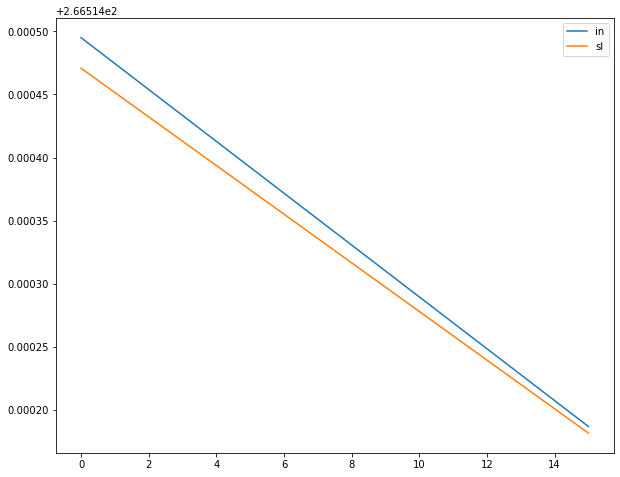

In [58]:
crds_in = ww.pixel_to_world(np.arange(1024), 64+np.zeros(1024))
crds_sl = wwsl.pixel_to_world(np.arange(16), np.zeros(16))
pl.plot(np.linspace(0,15,1024), crds_in.ra, label='in')
pl.plot(np.linspace(0,15,16), crds_sl.ra, label='sl')
pl.legend(loc='best');

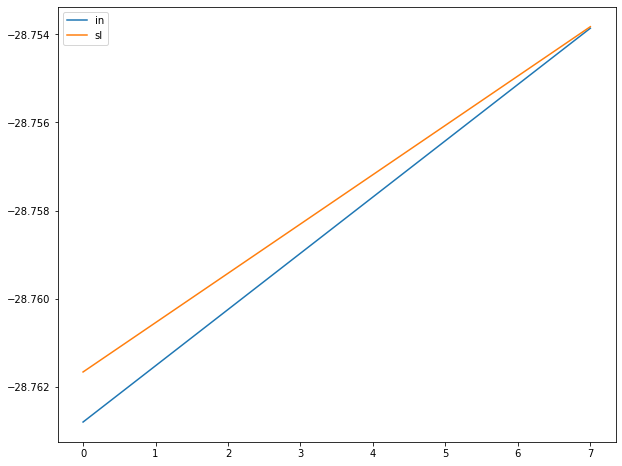

In [42]:
crds_in = ww.pixel_to_world(np.arange(512), np.zeros(512))
crds_sl = wwsl.pixel_to_world(np.arange(8), np.zeros(8))
pl.plot(np.linspace(0,7,512), crds_in.dec, label='in')
pl.plot(np.linspace(0,7,8), crds_sl.dec, label='sl')
pl.legend(loc='best');

In [43]:
ww.pixel_to_world(*ww.wcs.crpix-1), ww.world_to_pixel_values(*ww.wcs.crval), ww.wcs.crpix-1

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53563898, -28.71299863)>,
 (array(2828.5312141), array(1166.45507921)),
 array([2828.5312141 , 1166.45507921]))

In [44]:
wwsl.pixel_to_world(*wwsl.wcs.crpix-1), wwsl.world_to_pixel_values(*wwsl.wcs.crval), wwsl.wcs.crpix-1

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53563898, -28.71299863)>,
 (array(43.19580022), array(17.22586061)),
 array([43.19580022, 17.22586061]))

In [45]:
ww.pixel_to_world(*ww.wcs.crpix-1).separation(
    wwsl.pixel_to_world(*wwsl.wcs.crpix-1)
    )

<Angle 0. deg>

In [46]:
ww

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5356389808593  -28.712998625026  
CRPIX : 2829.531214097682  1167.45507920672  
PC1_1 PC1_2  : -0.01526213458185807  0.9998835268410042  
PC2_1 PC2_2  : 0.9998835268410042  0.01526213458185807  
CDELT : 1.74999921246059e-05  1.74999921246059e-05  
NAXIS : 5683  2329

In [47]:
wwsl

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5356389808593  -28.712998625026  
CRPIX : 44.19580022027628  18.225860612605  
PC1_1 PC1_2  : -0.01526213458185807  0.9998835268410042  
PC2_1 PC2_2  : 0.9998835268410042  0.01526213458185807  
CDELT : 0.0011199994959747775  0.0011199994959747775  
NAXIS : 5683  2329

In [48]:
wwsl.wcs.cdelt / ww.wcs.cdelt

array([64., 64.])

In [49]:
for fn in glob.glob(f'{basepath}/images/jw02221-o001_t001_nircam_*_i2d.fits'):
    hdu = fits.open(fn)
    filtername = hdu[0].header['PUPIL']
    if filtername in ('CLEAR', 'F444W'):
        filtername = hdu[0].header['FILTER']
    print(fn, filtername)

/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f212n_i2d.fits F212N
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f187n_i2d.fits F187N
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits F410M
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d.fits F405N
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits F182M
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f444w-f466n_i2d.fits F466N


In [50]:
from scipy.ndimage import median_filter, map_coordinates

# Check that the background interpolation works

In [51]:
input_image = f"{basepath}/F405N/pipeline/jw02221001001_03101_00024_nrcalong_cal.fits"

fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
destreaked = im2 = destreak_data(image, median_filter_size=15)

# reload b/c destreaking is inplace
fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
image.shape

(2048, 2048)

In [52]:
import pylab as plt

0 1


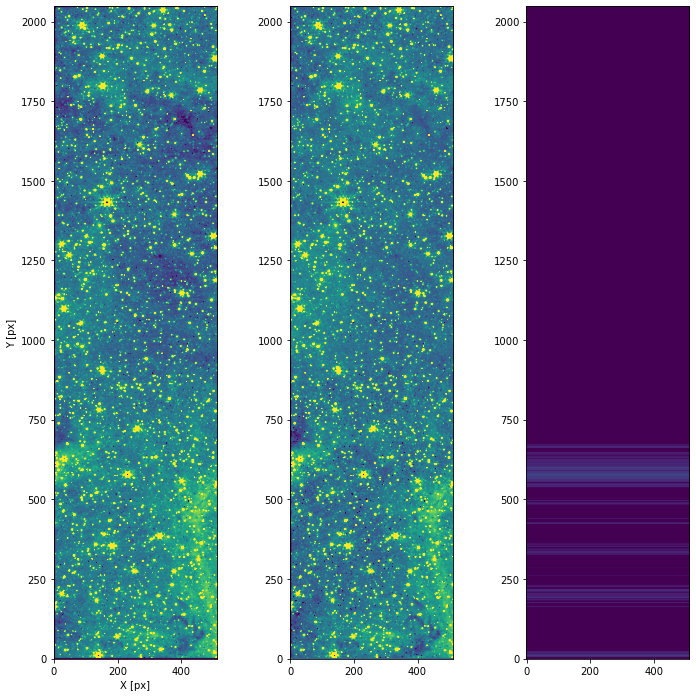

In [53]:
plt.figure(figsize=(12, 12))
#for start in range(0, 2048, 512):
start = 0
print(start, (start//512)+1)
ax = plt.subplot(1, 3, 1)
plt.xlabel("X [px]",)
plt.ylabel("Y [px]",)

norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 2).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.subplot(1, 3, 3).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
plt.show()

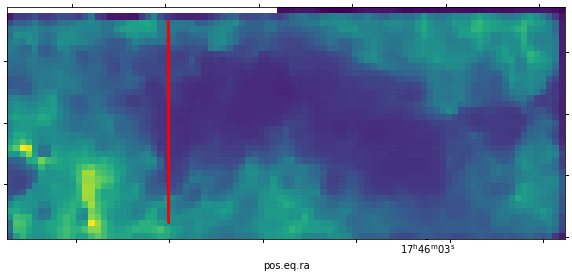

In [54]:
hdu = fits.open('/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d_medfilt128.fits')
wwbg = wcs.WCS(hdu[0].header)
ax = pl.subplot(projection=wwbg)
bg = hdu[0].data
ax.imshow(bg,)# norm=norm_to_match)

input_image = f"{basepath}/F405N/pipeline/jw02221001001_03101_00024_nrcalong_cal.fits"
hdu2 = fits.open(input_image)
ww2 = wcs.WCS(hdu2[1].header)

crds = ww2.pixel_to_world(np.ones(2048) + 1280, np.arange(2048))
ax.scatter(crds.ra, crds.dec, transform=ax.get_transform('world'), edgecolor='r', facecolor='none', s=1)

bgx, bgy = wwbg.world_to_pixel(crds)

bg_sampled = map_coordinates(bg, [bgy, bgx], order=1)

Background filename: /orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d_medfilt128.fits
bg_sampled shape: (2048,), nanmedian: 16.803116487273073
bg_sampled shape: (2048,), nanmedian: 13.614294620960102
bg_sampled shape: (2048,), nanmedian: 5.810082344127032
bg_sampled shape: (2048,), nanmedian: 5.627606442085474
0 1


/scratch/local/47745774/ipykernel_43924/2220938512.py:30: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=im)


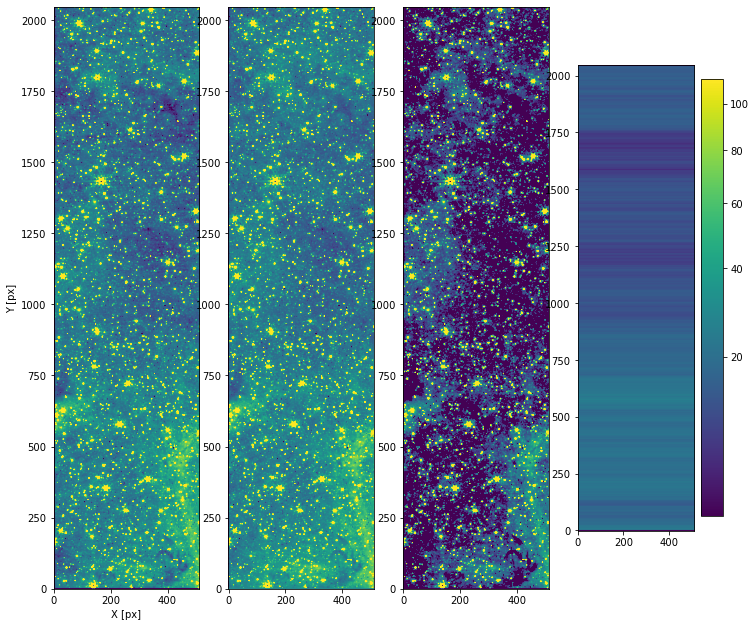

512 2


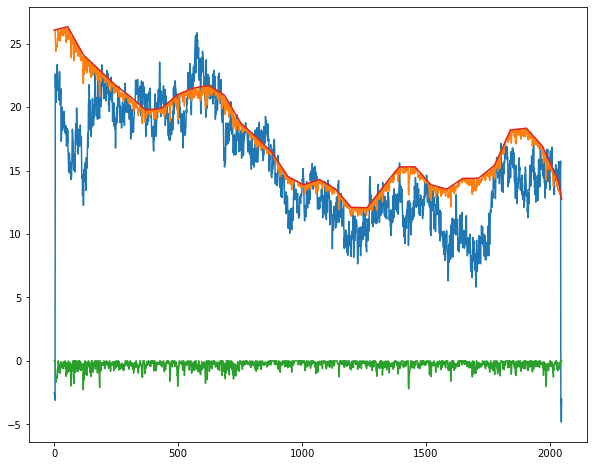

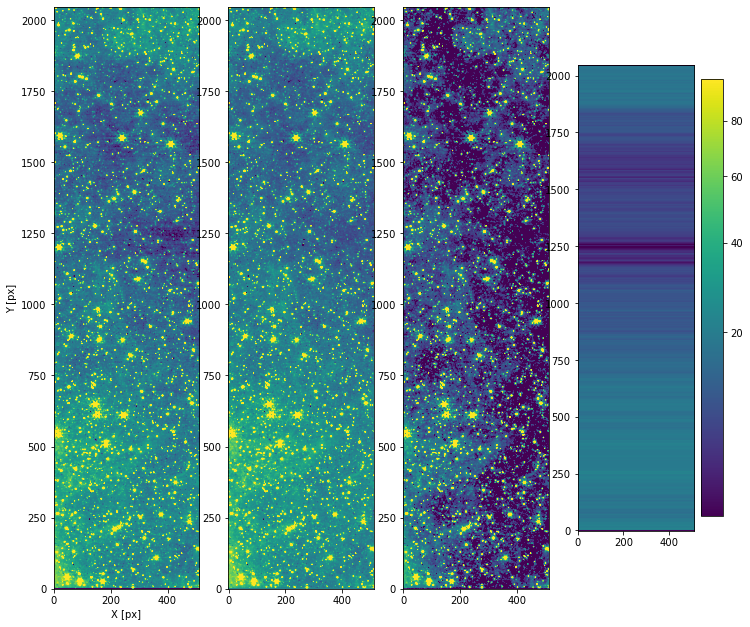

1024 3


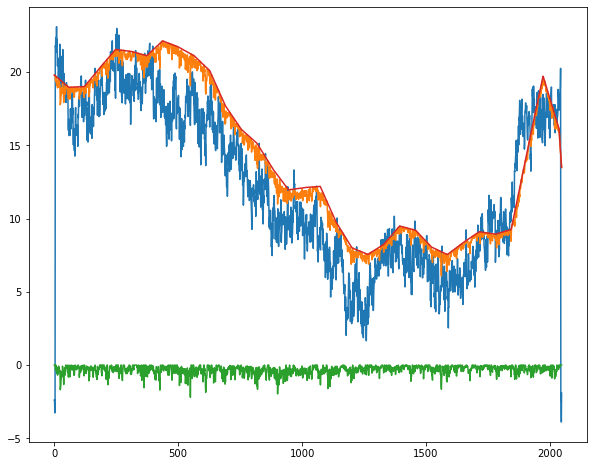

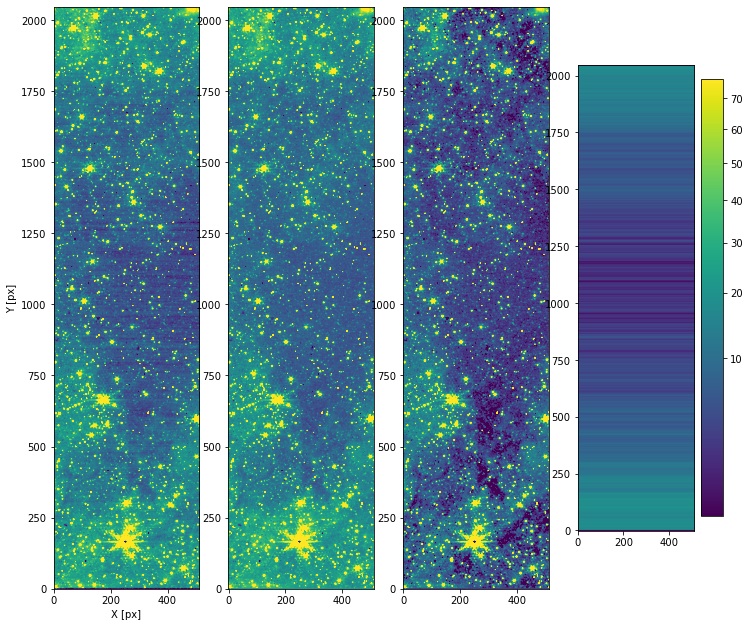

1536 4


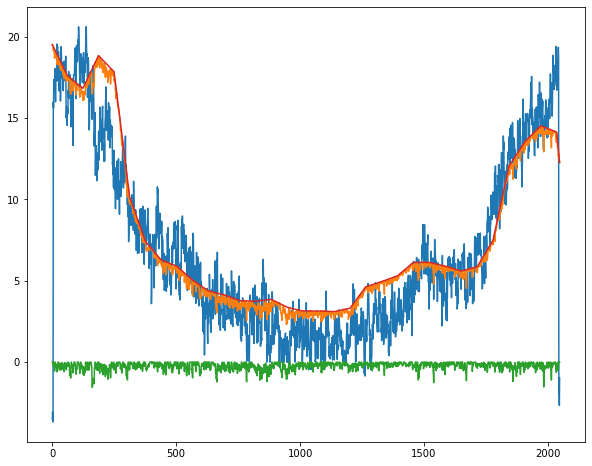

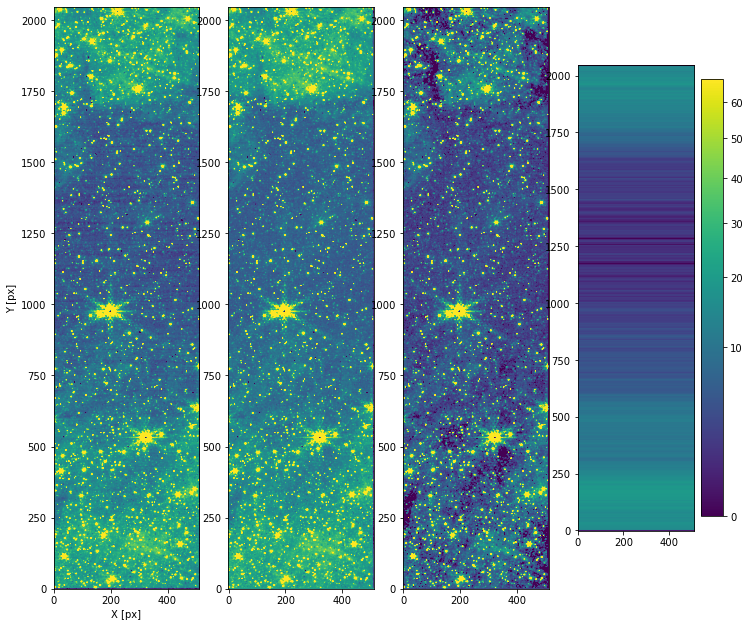

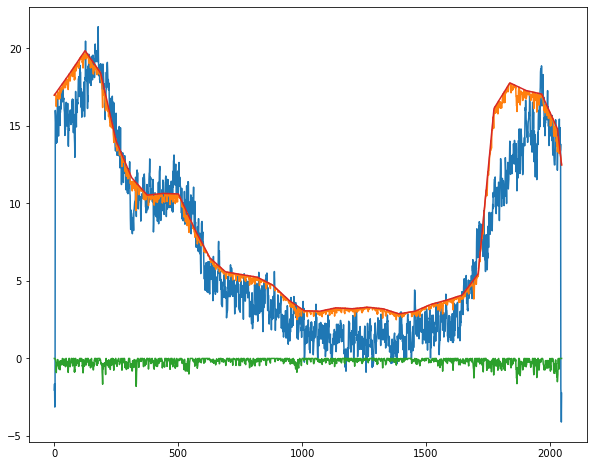

In [56]:
#input_image = f"{basepath}/F187N/pipeline/jw02221001001_03101_000{ii:02d}_nrcb3_cal.fits" # 03101 = PaA
input_image = f"{basepath}/F405N/pipeline/jw02221001001_03101_00024_nrcalong_cal.fits"

fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
destreaked = im2 = destreak_data(image, median_filter_size=2048, add_smoothed=False)
destreaked_bg = add_background_map(destreaked.copy(), hdu, verbose=True)

# reload b/c destreaking is inplace
fh = hdu = fits.open(input_image)
image = im1 = hdu[1].data
image.shape

for start in range(0, 2048, 512):

    plt.figure(figsize=(12, 12))
    #for start in range(0, 2048, 512):
    print(start, (start//512)+1)
    ax = plt.subplot(1, 4, 1)
    plt.xlabel("X [px]")
    plt.ylabel("Y [px]")

    norm_to_match = simple_norm(im1[:, slice(start, start+512)], 'sqrt', percent=95.)
    im = ax.imshow(im1[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
    plt.subplot(1, 4, 2).imshow(destreaked_bg[:, slice(start, start+512)],
                                #/np.percentile(im1[:, slice(start, start+512)], 10, axis=1)[:,None],
                                norm=norm_to_match, cmap='viridis')
    plt.subplot(1, 4, 3).imshow(destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
    plt.subplot(1, 4, 4).imshow(im1[:, slice(start, start+512)] - destreaked[:, slice(start, start+512)], norm=norm_to_match, cmap='viridis')
    plt.colorbar(mappable=im)
    plt.show()

    plt.figure()
    #plt.plot(np.percentile(im1[:, slice(start, start+512)], 1, axis=1))
    #plt.plot(np.percentile(im1[:, slice(start, start+512)], 5, axis=1))
    plt.plot(np.percentile(im1[:, slice(start, start+512)], 10, axis=1))
    plt.plot(np.percentile(destreaked_bg[:, slice(start, start+512)], 10, axis=1))
    plt.plot(np.percentile(destreaked[:, slice(start, start+512)], 10, axis=1))
    
    crds = ww2.pixel_to_world(np.zeros(2048) + start + 256, np.arange(2048))
    bgx, bgy = wwbg.world_to_pixel(crds)
    bg_sampled = map_coordinates(bg, [bgy, bgx], order=1)

    #plt.plot(np.percentile(im1[:, slice(start, start+512)], 50, axis=1))
    plt.plot(bg_sampled)